In [18]:
from IPython.display import display
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, log_loss, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skcmeans.algorithms import Probabilistic
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neural_network import MLPRegressor

plt.rcParams['figure.figsize'] = [15, 7]

## Ý tưởng

Sử dụng nhiều model giải quyết vấn đề của bài toán PERM có khỏang giá trị rộng (1e-3 - 8000)

* Sử dụng model CMeans phân cụm dữ liệu theo đầu vào hoặc đầu ra.

* Sử dụng model classification training trên với label sinh ra từ CMeans.

* Sử dụng nhiều model regression training trên từng cụm dữ liệu với đầu ra là PERM.

* Trong quá trình đưa dữ liệu mới vào, model classification sẽ phân loại đầu vào, từ đó sẽ quyết định tới việc sử dụng model regression nào cho phù hợp.

In [19]:
def input_fn(ftrain, fval):
    """Specify process load data for this paper
    
    Parameters
    ----------
    ftrain: string, path to file csv dataset for trainning
    
    fval: string, path to file csv dataset for validation
    
    Returns
    -------
    df_train: pandas DataFrame, table training set with header and no index
    
    df_val: pandas DataFrame, table training set with header and no index
    
    Notes
    -----
    File must be .csv format with first line is header and no index
    """
    df_train = pd.read_csv(ftrain, header=0, index_col=None)
    if not fval is None:
        df_val = pd.read_csv(fval, header=0, index_col=None)
    else:
        df_val = None
        
    return df_train, df_val

In [20]:
def clustering(dataset, n_clusters=6, by='target'):
    """Clustering process perform cluster dataset by data or target
    
    Parameters
    ----------
    dataset: pandas DataFrame, default last column is target

    n_clusters: int, number of clusters
    
    by: string, `data` or `target`, target for clustering process, default `target`
    
    Returns
    -------
    dataset_with_labels: pandas DataFrame, dataset assigned label, columns labels is last
    """
    distances = []
    data = dataset.values[:,:-1]
    target = dataset.values[:,-1].reshape(-1,1)
    cluster = Probabilistic(n_clusters=n_clusters, random_state=1)
    
    if by not in ['data', 'target']:
        print('No support')
        return None
    if by == 'target':
        cluster.fit(target)
        distances = cluster.distances(target)
    else:
        cluster.fit(data)
        distances = cluster.distances(data)
    
    labels = np.argmin(distances, axis=1)
    labels = pd.DataFrame(data=labels, columns=['LABEL'])
    dataset_with_labels = pd.concat([dataset, labels], axis=1)
    
    return dataset_with_labels

In [21]:
def gen_classifier(dataset, disp=True):
    """Perform setting and generate a classifier from DataFrame with labels
    
    Parameters
    ----------    
    dataset: pandas DataFrame, default last column is labels
    
    disp: bool, display report if True
    
    Returns
    -------
    classifier: object of clf, trained with data
    """
    data = dataset.values[:,:-2]
    labels = dataset.values[:,-1]
    steps = [('std', StandardScaler()),
             ('estimator', XGBClassifier(n_estimators=300, max_depth=30))]
    classifier = Pipeline(steps)
    classifier.fit(data, labels)
    
    if disp:
        loss = 0
        accuracy = 0
        labels_pred = classifier.predict(data)
        #loss = log_loss(y_pred=labels_pred, y_true=labels)
        accuracy = accuracy_score(y_pred=labels_pred, y_true=labels)
        cm = confusion_matrix(y_pred=labels_pred, y_true=labels)
        print('Classifier report')
        print('-----------------')
        print(f'Loss: {loss}')
        print(f'Accuracy: {accuracy}')
        plt.imshow(X=cm, cmap=plt.cm.Blues, interpolation='nearest')
        plt.title('Confusion matrix for classifier')
        plt.colorbar()
        plt.show()
    
    return classifier

In [22]:
def gen_estimators(dataset, disp=True):
    """Perform generate model regression for PERM
    
    Parameters
    ----------
    dataset: pandas DataFrame, default last colum is labels
    
    disp: bool, display report if True
    
    Returns
    -------
    estimators: list of regressor
    """
    n_models = len(set(dataset.values[:,-1]))
    estimators = []
    for i in range(n_models):
        steps = [('std', MinMaxScaler()),
                 ('estimator', XGBRegressor(n_estimators=300, max_depth=30))]
        estimators.append(Pipeline(steps))
    groups = dataset.groupby('LABEL')
    
    for group in groups:
        index = group[0]
        data = group[1].values[:,:-2]
        target = group[1].values[:,-2]
        estimators[index].fit(data, target)
        
        if disp:
            target_pred = estimators[index].predict(data)
            mae = mean_absolute_error(y_true=target, y_pred=target_pred)
            mse = mean_squared_error(y_true=target, y_pred=target_pred)
            error = abs(target - target_pred)
            print(f'Estimator {index} report')
            print('-------------------')
            print(f'MSE: {mse}')
            print(f'MAE: {mae}')
            plt.hist(error, bins=50)
            plt.title('Distributed error')
            plt.show()
    
    return estimators

In [23]:
def save_models(classifier, estimators, fmodels=None):
    """Perform combine and dump pickle to file with name is fmodels
    
    Parameters
    ----------
    classifier: object, it trained
    
    estimators: list of object, it trained
    
    fmodels: string, if fmodel is not None, it is name of dump file
    
    Returns
    -------
    models: dict, keys: classifier and estimators
    """
    models = dict(classifier=classifier, estimators=estimators)
    if not fmodels is None:
        with open(fmodels, 'wb') as dump_file:
            pickle.dump(models, dump_file)
    return models

In [24]:
def predict(models, data):
    """Perform predict data using models and data
    
    Parameters
    ----------
    models: dict, models combined
    data: ndarray (n_samples, 6), a numpy array has 6 features
    
    Returns
    -------
    perm: ndarray (n_samples,), a 1d numpy array is perm 
    """
    labels = models['classifier'].predict(data).astype(int)
    y_pred = []
    for i in range(len(labels)):
        index = labels[i]
        x = data[i]
        y = models['estimators'][index].predict([x])
        y_pred.append(y[0])
    
    y_pred = np.array(y_pred).reshape(-1)
    
    return y_pred

In [25]:
def create_models(ftrain='train.csv', fval='val.csv', n_clusters=8, fmodels='himpe'):
    """Perform create models
    
    Parameters
    ----------
    ftrain: string, path to csv file training dataset
    fval: string, path to csv file training dataset
    n_clusters: int, numbe of cluster
    fmodels: string, path to dump file models
    
    Returns
    -------
    models: dict
    """
    df_train, df_val = input_fn(ftrain, fval)
    df_with_label = clustering(dataset=df_train, by='data', n_clusters=n_clusters)
    classifer = gen_classifier(dataset=df_with_label, disp=True)
    estimators = gen_estimators(dataset=df_with_label, disp=True)
    save_models(classifier=classifer, estimators=estimators, fmodels=fmodels)
    if not df_val is None:
        evaluate(df_val, models)
    
    return models

In [26]:
def evaluate(df_val, models):
    x_val = df_val.values[:,:-1]
    y_val = df_val.values[:,-1]
    y_pred = predict(models=models, data=x_val)
    x = list(range(len(y_val)))
    error = abs(y_val-y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    print('Models report')
    print('-------------')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    plt.hist(error, bins=100)
    plt.xlabel('Error')
    plt.ylabel('n sample')
    plt.title('Report error')
    plt.show()

    plt.plot(x, y_val, label='Actual')
    plt.plot(x, y_pred, label='Predict')
    plt.legend()
    plt.show()

### Config and load dataset

In [27]:
fmodels = 'himpe'
ftrain = 'train.csv'
fval = 'val.csv'
n_clusters = 8

df_train, df_val = input_fn(ftrain, fval)
display(df_train.describe(), df_val.describe())

,GR,NPHI,RHOB,DT,VCL,PHIE,PERM_CORE
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,82.484089,1.539995,36.065923,173.169454,0.784944,0.120373,189.459868
std,32.426194,4.633091,271.513684,508.339513,3.093680,0.070277,490.383317
min,9.721700,0.000000,2.010400,2.270000,0.000000,0.000000,0.000100
25%,59.515600,0.119600,2.353900,69.752500,0.088000,0.076300,0.180000
50%,79.299450,0.156450,2.434250,74.184198,0.158200,0.112619,5.079300
75%,98.960550,0.224000,2.484650,80.801425,0.284100,0.161300,90.372675
max,267.060211,32.326800,2370.562000,2830.901600,29.430300,0.999700,8700.000000


,GR,NPHI,RHOB,DT,VCL,PHIE,PERM_CORE
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,82.574070,1.138887,48.466470,205.902290,1.085221,0.128096,212.061866
std,28.801440,3.872197,317.149657,583.852710,4.145166,0.092570,610.256267
min,13.804300,0.013300,2.012700,2.420000,0.000000,0.000000,0.000400
25%,59.616025,0.119050,2.350675,69.781951,0.091750,0.073400,0.187950
50%,79.014750,0.154850,2.434200,75.238950,0.157200,0.118500,6.456399
75%,99.613928,0.228300,2.490875,82.086875,0.281300,0.167425,112.097500
max,173.272400,19.925000,2307.865200,2828.438400,32.326800,0.877800,8700.000000


### Generate data with label

In [28]:
df_with_label = clustering(dataset=df_train, by='data', n_clusters=n_clusters)
display(df_with_label.describe(), df_with_label.head(5))

,GR,NPHI,RHOB,DT,VCL,PHIE,PERM_CORE,LABEL
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,82.484089,1.539995,36.065923,173.169454,0.784944,0.120373,189.459868,4.938800
std,32.426194,4.633091,271.513684,508.339513,3.093680,0.070277,490.383317,1.757808
min,9.721700,0.000000,2.010400,2.270000,0.000000,0.000000,0.000100,0.000000
25%,59.515600,0.119600,2.353900,69.752500,0.088000,0.076300,0.180000,4.000000
50%,79.299450,0.156450,2.434250,74.184198,0.158200,0.112619,5.079300,5.000000
75%,98.960550,0.224000,2.484650,80.801425,0.284100,0.161300,90.372675,6.000000
max,267.060211,32.326800,2370.562000,2830.901600,29.430300,0.999700,8700.000000,7.000000


,GR,NPHI,RHOB,DT,VCL,PHIE,PERM_CORE,LABEL
0,77.0222,0.3403,2.3864,110.3568,0.6287,0.1170,97.0000,6
1,64.7020,15.5441,2.3601,79.8485,0.0723,0.1644,23.7000,4
2,103.7312,0.1999,2296.7898,96.8336,0.0000,0.1711,69.0000,3
3,98.6601,0.2302,2.3116,79.6258,0.2152,0.1790,142.0000,6
4,110.5277,0.1719,2.6596,74.9140,0.6558,0.0001,0.1004,7


### Generate classifier

/home/nkthanh/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classifier report
-----------------
Loss: 0
Accuracy: 1.0


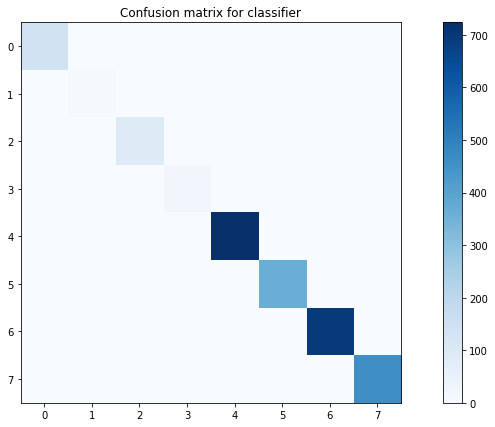

In [29]:
classifer = gen_classifier(dataset=df_with_label, disp=True)

### Generate regressor

Estimator 0 report
-------------------
MSE: 3.99654050151158e-07
MAE: 0.0004288049826055003


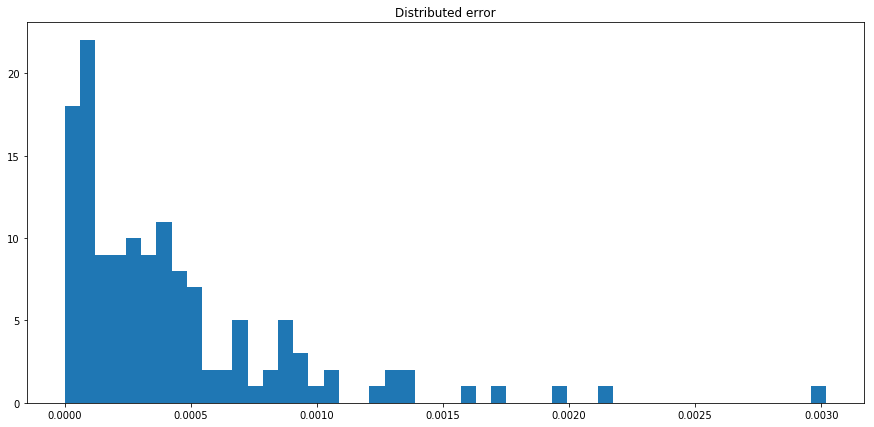

Estimator 1 report
-------------------
MSE: 4.999464991585968e-07
MAE: 0.0005352367054333678


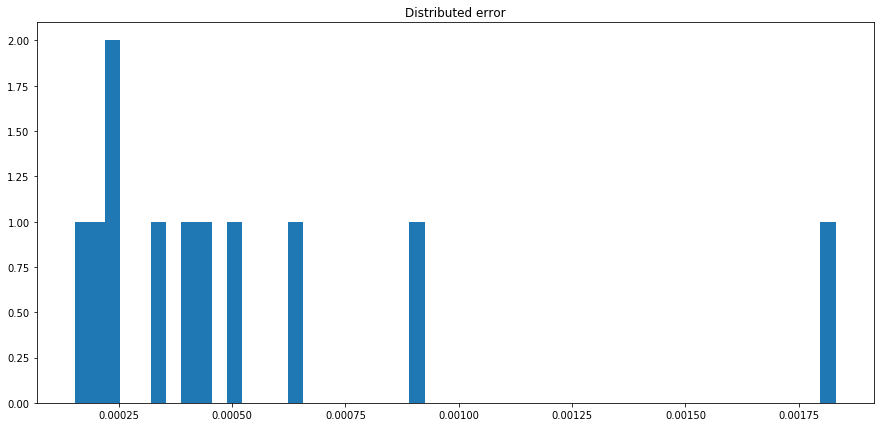

Estimator 2 report
-------------------
MSE: 5.559510547190799e-07
MAE: 0.0005391574350635585


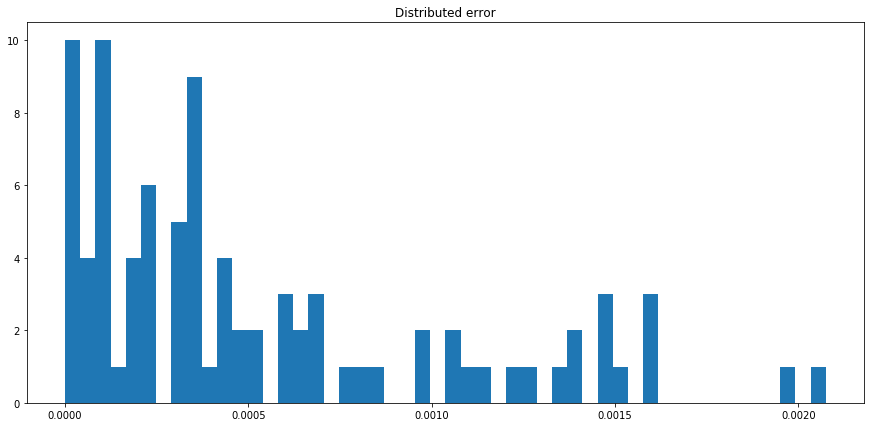

Estimator 3 report
-------------------
MSE: 6.481117394409681e-07
MAE: 0.0005858104228980342


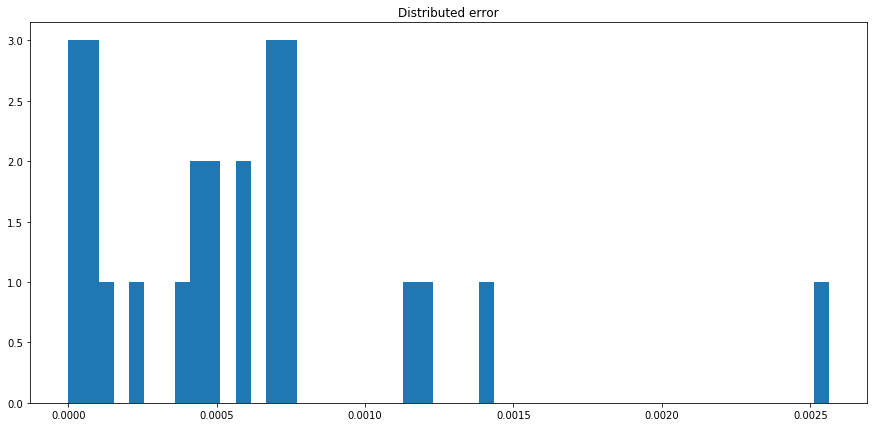

Estimator 4 report
-------------------
MSE: 4.613155513531135e-07
MAE: 0.0004673730163365959


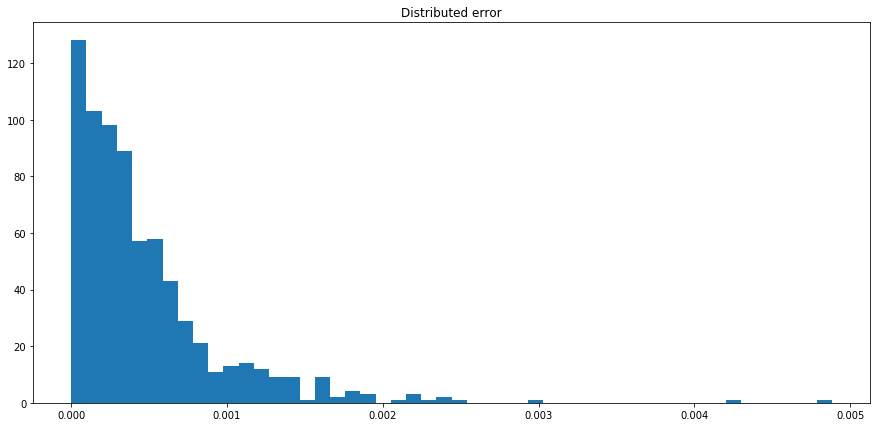

Estimator 5 report
-------------------
MSE: 5.085711357919523e-07
MAE: 0.0004900556035741826


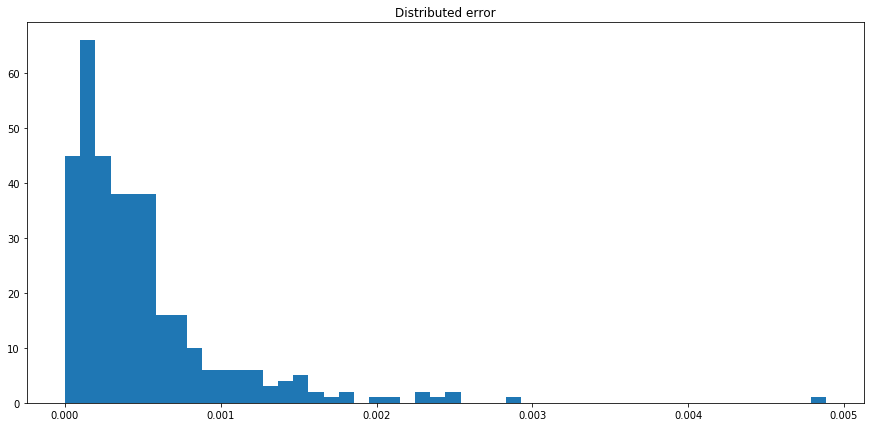

Estimator 6 report
-------------------
MSE: 1.1461047737500836e-05
MAE: 0.0010942510780944724


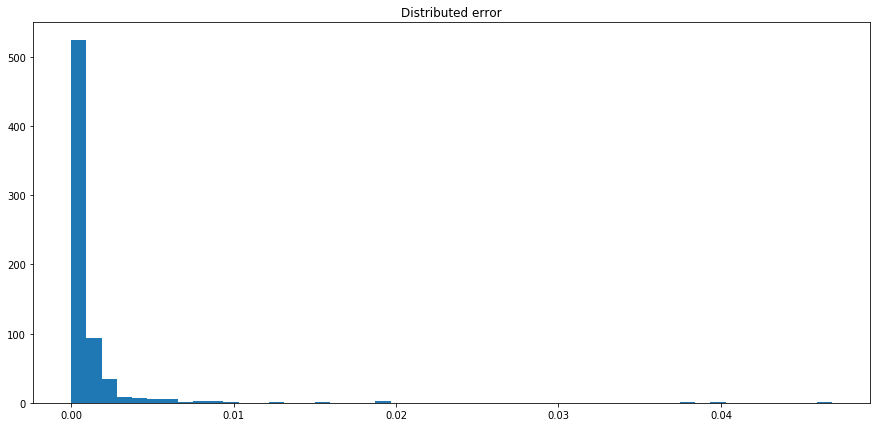

Estimator 7 report
-------------------
MSE: 5.322060679970684e-07
MAE: 0.00042036917794535824


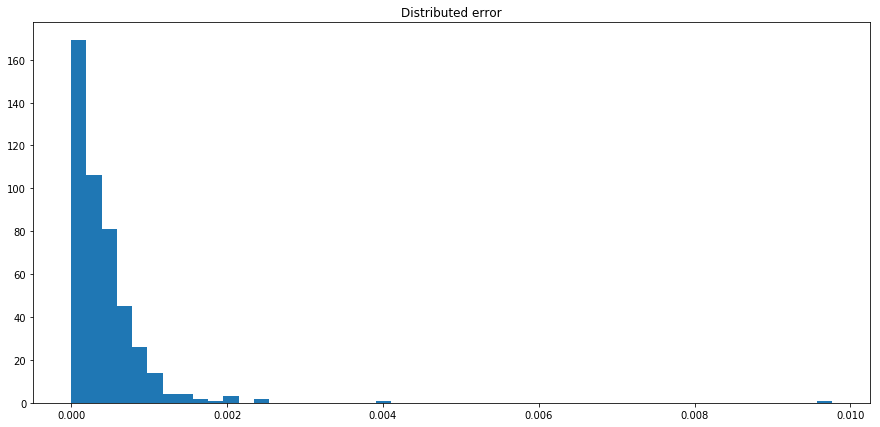

In [30]:
estimators = gen_estimators(dataset=df_with_label, disp=True)

### Combine models

In [31]:
models = save_models(classifier=classifer, estimators=estimators, fmodels='himpe')

### Evaluate models

/home/nkthanh/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Models report
-------------
MAE: 130.2824865632046
MSE: 248265.93123832907


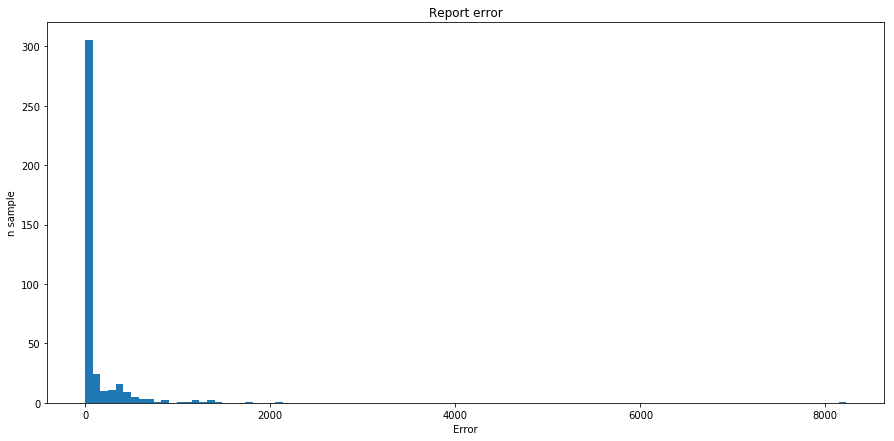

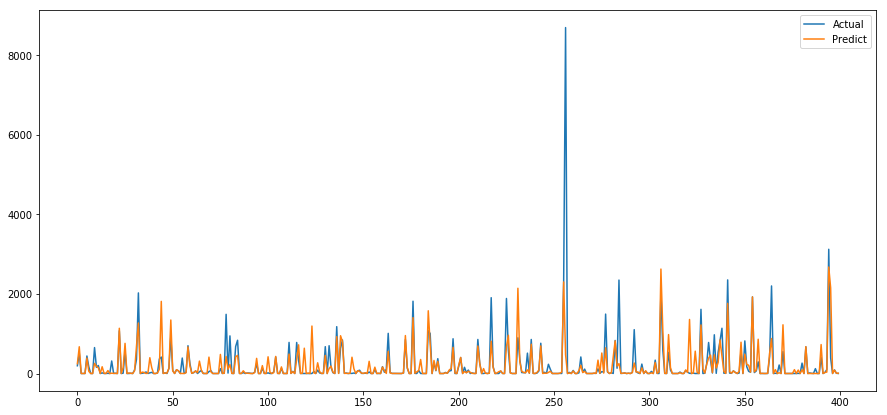

In [32]:
x_val = df_val.values[:,:-1]
y_val = df_val.values[:,-1]
y_pred = predict(models=models, data=x_val)
x = list(range(len(y_val)))
error = abs(y_val-y_pred)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
print('Models report')
print('-------------')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
plt.hist(error, bins=100)
plt.xlabel('Error')
plt.ylabel('n sample')
plt.title('Report error')
plt.show()

plt.plot(x, y_val, label='Actual')
plt.plot(x, y_pred, label='Predict')
plt.legend()
plt.show()